# Graduate Admission Predictions

Let us first import the pertinent libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
admissions = pd.read_csv('admissions.csv')

In [3]:
admissions.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [4]:
admissions = admissions.rename(columns = {'Chance of Admit ':'Chance of Admit'})

In [5]:
print(admissions.isnull().sum())

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64


In [6]:
admissions.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


### Outlier Detection: Turkey Method and Z-Score Method

We want to deal with outliers because they can significantly impact predictions, especially in regression problems. We will first use the Tukey method, as introduced by Tukey in 1977 (https://www.stat.cmu.edu/~cshalizi/statcomp/13/labs/05/lab-05.pdf). 

This method looks at the range between the 1st and 3rd quartiles of the data (IQR). If a feature value falls outside this range plus or minus a calculated outlier step, it's considered an outlier.

We will specifically focus on numerical features like GRE Score, TOEFL Score, University Rating, SOP, LOR, CGPA, and Research. For the outlier detection, we will identify rows with at least two numerical values that are considered outliers.

In [7]:
def find_outliers(data, threshold, attributes):
    
    # Identify observations with more than 'threshold' outliers using the Tukey method.
    
    outlier_indices = []
    
    # Loop through each attribute
    for attribute in attributes:
        # Calculate quartiles
        first_quartile = np.percentile(data[attribute], 25)
        third_quartile = np.percentile(data[attribute], 75)
        
        # Calculate interquartile range (IQR)
        iqr = third_quartile - first_quartile
        
        # Set outlier step
        outlier_step = 1.5 * iqr
        
        # Find outliers for the current attribute
        outliers = data[(data[attribute] < first_quartile - outlier_step) | 
                         (data[attribute] > third_quartile + outlier_step)].index
        
        # Append outlier indices to the list
        outlier_indices.extend(outliers)
    
    # Count occurrences of each index
    index_counter = Counter(outlier_indices)
    
    # Select indices with more than 'threshold' occurrences
    multiple_outliers = list(index for index, count in index_counter.items() if count > threshold)
    
    return multiple_outliers

outliers_to_drop = find_outliers(admissions, 2, ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research'])

In [8]:
admissions.loc[outliers_to_drop] # Show the outliers rows

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit


We will also check for outliers using the Z-score method. The Z-score method for outliers aims to identify data points in a dataset that deviate significantly from the mean by measuring how many standard deviations they are from the mean. The goal is to flag observations that fall outside a chosen threshold, often set at a Z-score of 3.

This method provides a standardized way to assess the relative position of data points within a distribution, making it easier to identify values that are unusually high or low compared to the rest of the data. In essence, the Z-score method helps highlight potential outliers based on their deviation from the typical behavior of the dataset.

In [9]:
# Calculate Z-scores for each column
z_scores = zscore(admissions)

# Define a threshold for Z-scores (e.g., 3)
threshold = 3

# Identify outliers using the Z-score
outliers_zscore = admissions[(z_scores > threshold).any(axis=1)]

# Display or handle outliers as needed
print("Outliers detected using Z-score:")
print(outliers_zscore)

Outliers detected using Z-score:
Empty DataFrame
Columns: [Serial No., GRE Score, TOEFL Score, University Rating, SOP, LOR , CGPA, Research, Chance of Admit]
Index: []


No Extreme Values: The absence of outliers suggests that our dataset doesn't contain extreme values that are far from the mean. All the data points are within a certain range, and there are no observations that significantly deviate from the overall pattern of the data.

In [10]:
cols = admissions.drop(labels='Serial No.',axis=1)
cols.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


### Simple Exploratory Data Analysis

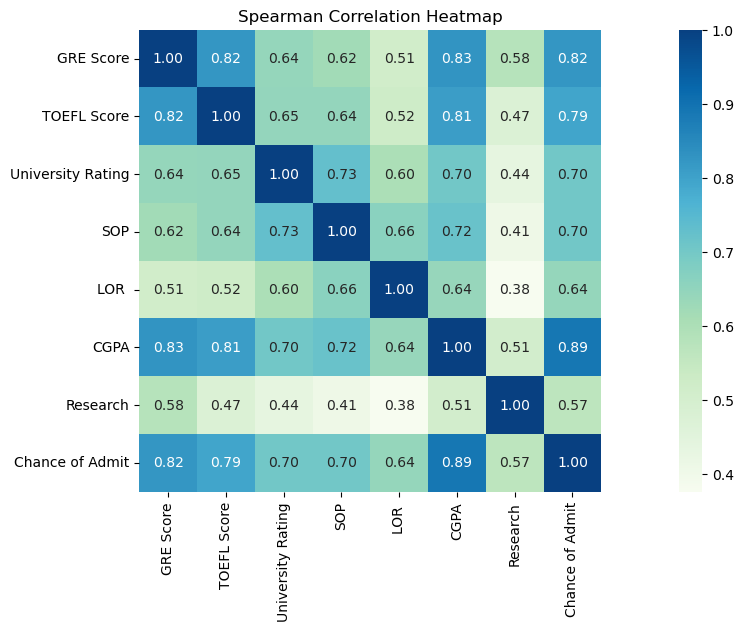

In [11]:
corr = cols.corr(method='spearman')
plt.figure(figsize=(20, 6))
sns.heatmap(corr, square=True, annot=True, fmt='.2f', cmap='GnBu')
plt.title('Spearman Correlation Heatmap')
plt.show()

Here we can see that the chance of admit is highly correlated with CGPA, GRE and TOEFEL scores are also correlated.

<Figure size 2000x1000 with 0 Axes>

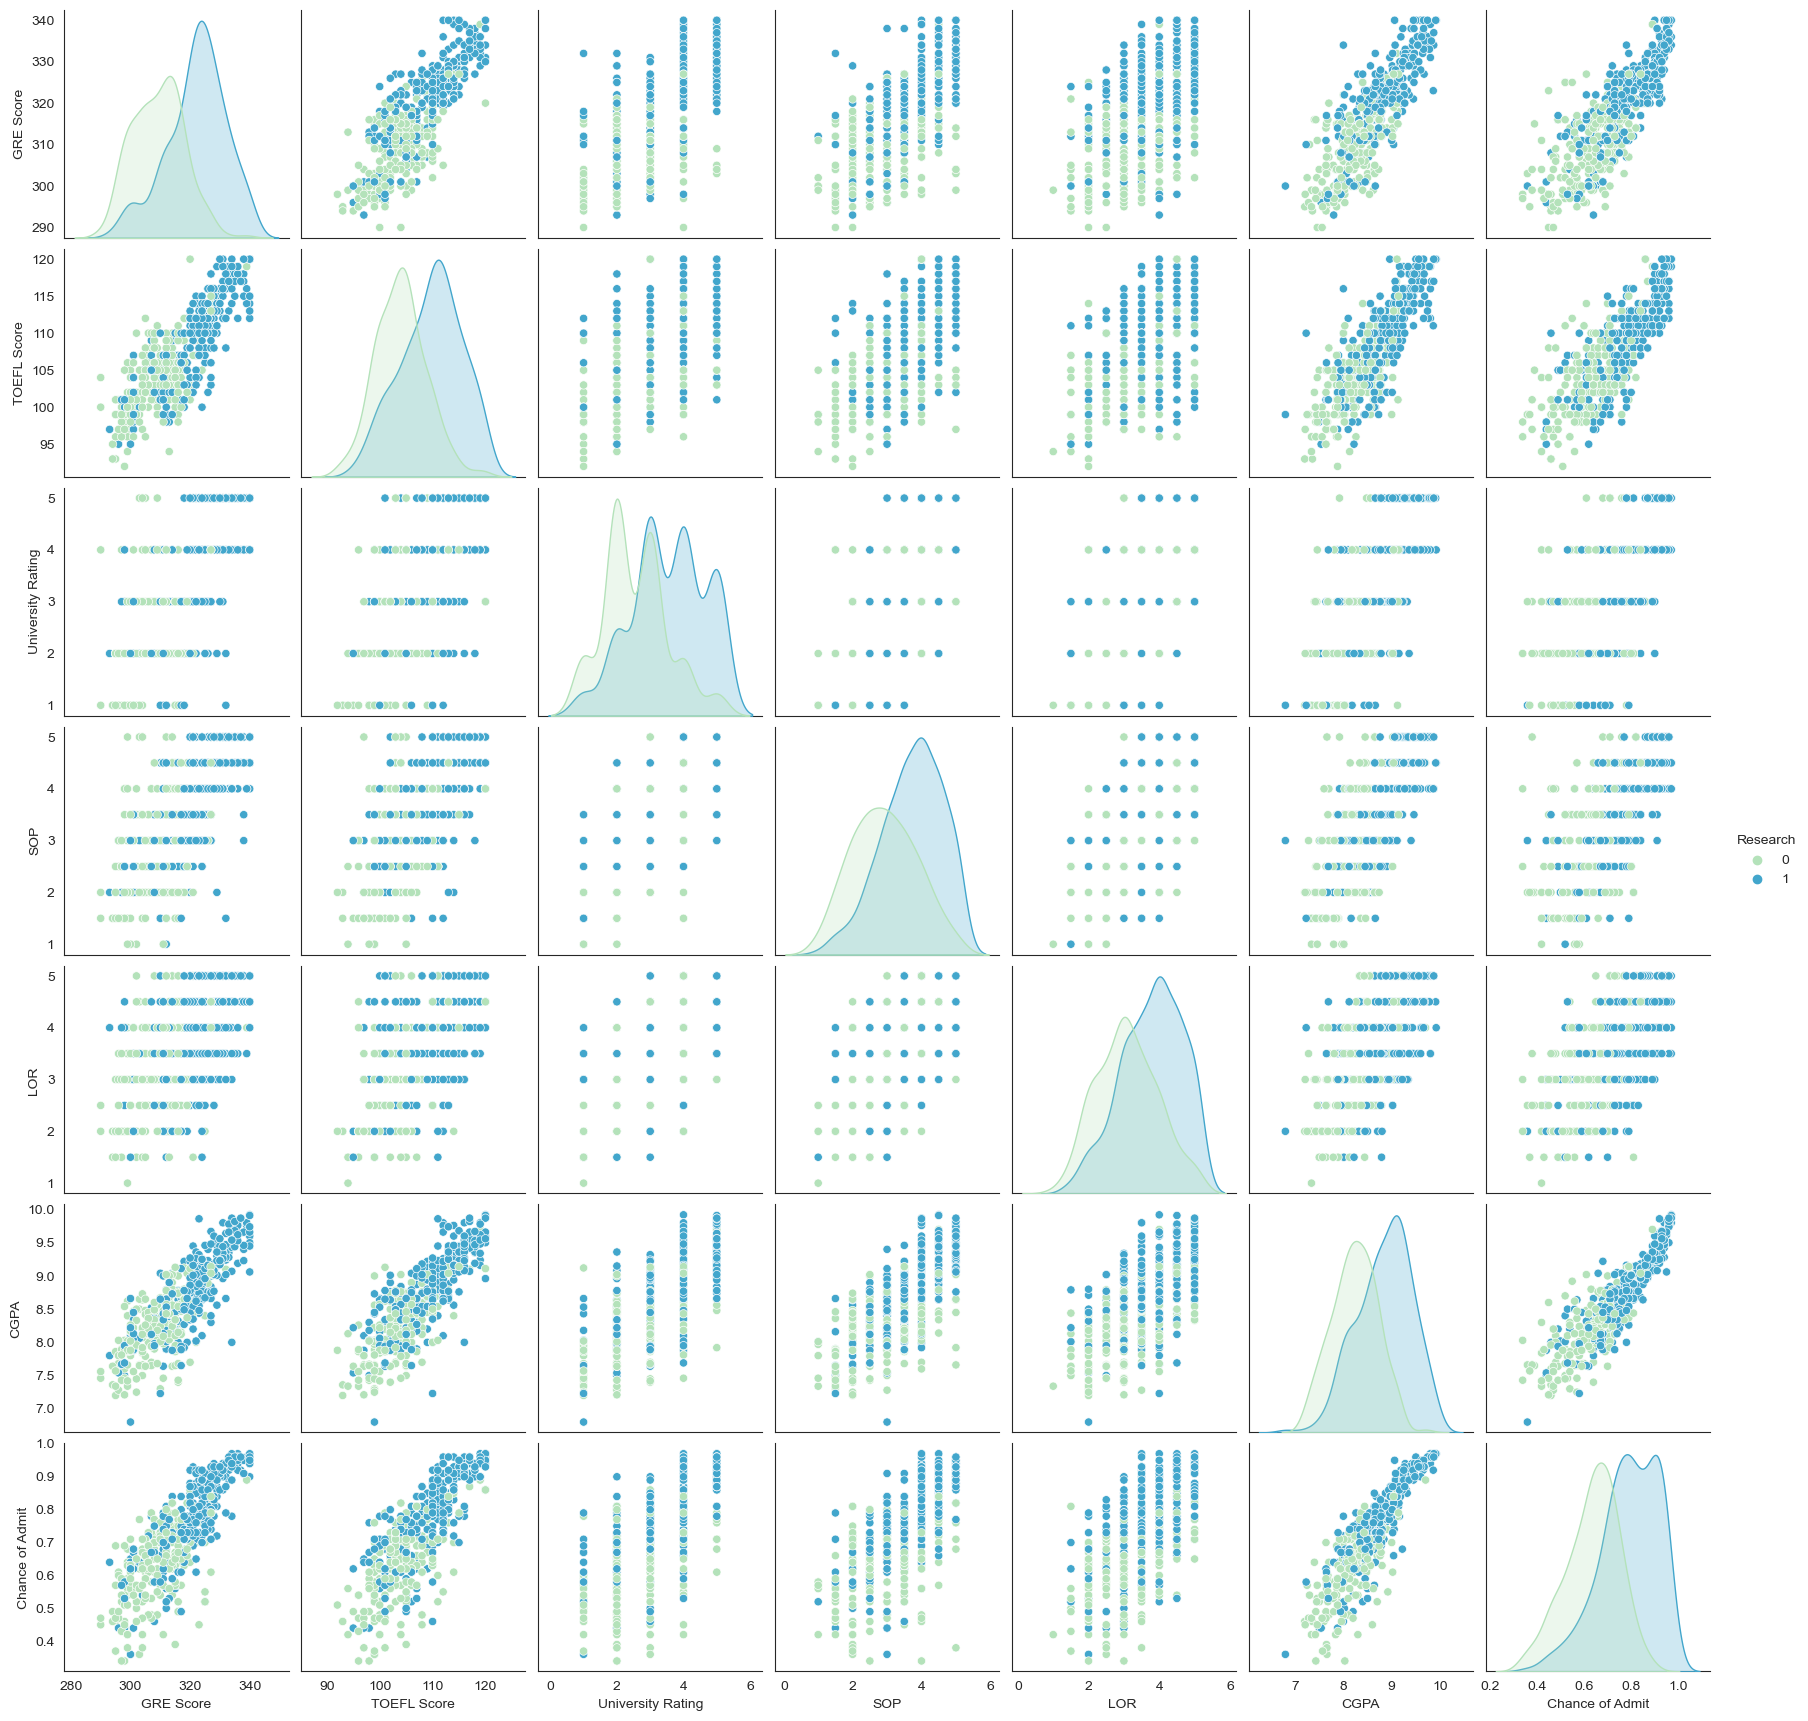

In [12]:
sns.set_style("white")
figure = plt.figure(figsize=(20,10))
sns.pairplot(cols, hue='Research', palette='GnBu')
plt.show()

GRE score TOEFL score and CGPA all are linearly related to each other.

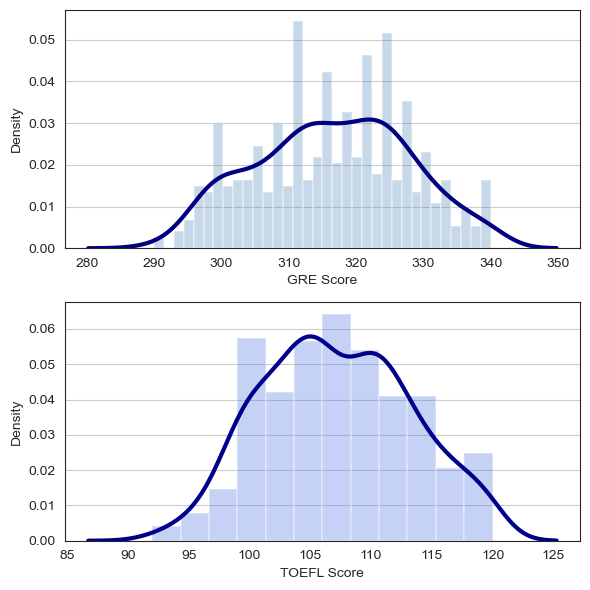

In [13]:
plt.figure(figsize=(6, 6))


plt.subplot(2, 1, 1)
gre_plot = sns.distplot(admissions['GRE Score'], bins=34, color='steelblue', kde_kws={"color": "navy", "lw": 3, "label": "KDE"},
             hist_kws={"linewidth": 1.5, "alpha": 0.3})
gre_plot.yaxis.grid(True)

plt.subplot(2, 1, 2)
toefl_plot = sns.distplot(admissions['TOEFL Score'], bins=12, color='royalblue', kde_kws={"color": "darkblue", "lw": 3, "label": "KDE"},
             hist_kws={"linewidth": 1.5, "alpha": 0.3})
toefl_plot.yaxis.grid(True)

plt.tight_layout()
plt.show()

From the above 3 graphs, people tend to score above 310 in GRE, above 100 in TOEFL. Moreover, most university ratings fall between 2 and 3.

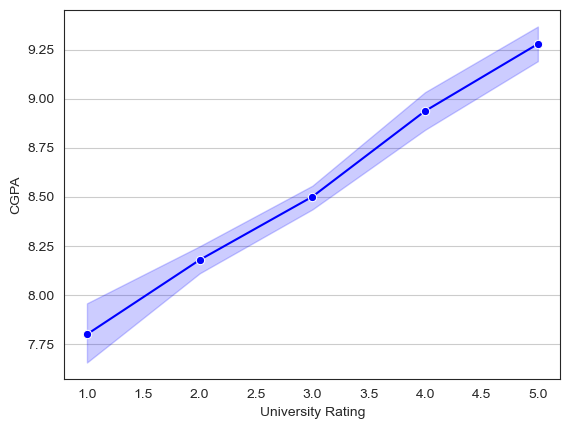

In [14]:
cgpa_plot = sns.lineplot(x='University Rating', y='CGPA', data=admissions, color='blue', marker="o")
cgpa_plot.yaxis.grid(True)

We can observe that university ratings increase with the increase in the CGPA.

Now lets set some cut-off scores and try to analyse scores above the cut-off.

In [15]:
co_gre=admissions[admissions["GRE Score"]>=320] #from https://collegedunia.com/exams/gre/cutoff
co_toefl=admissions[admissions["TOEFL Score"]>=100] #from https://collegedunia.com/exams/toefl/cutoff

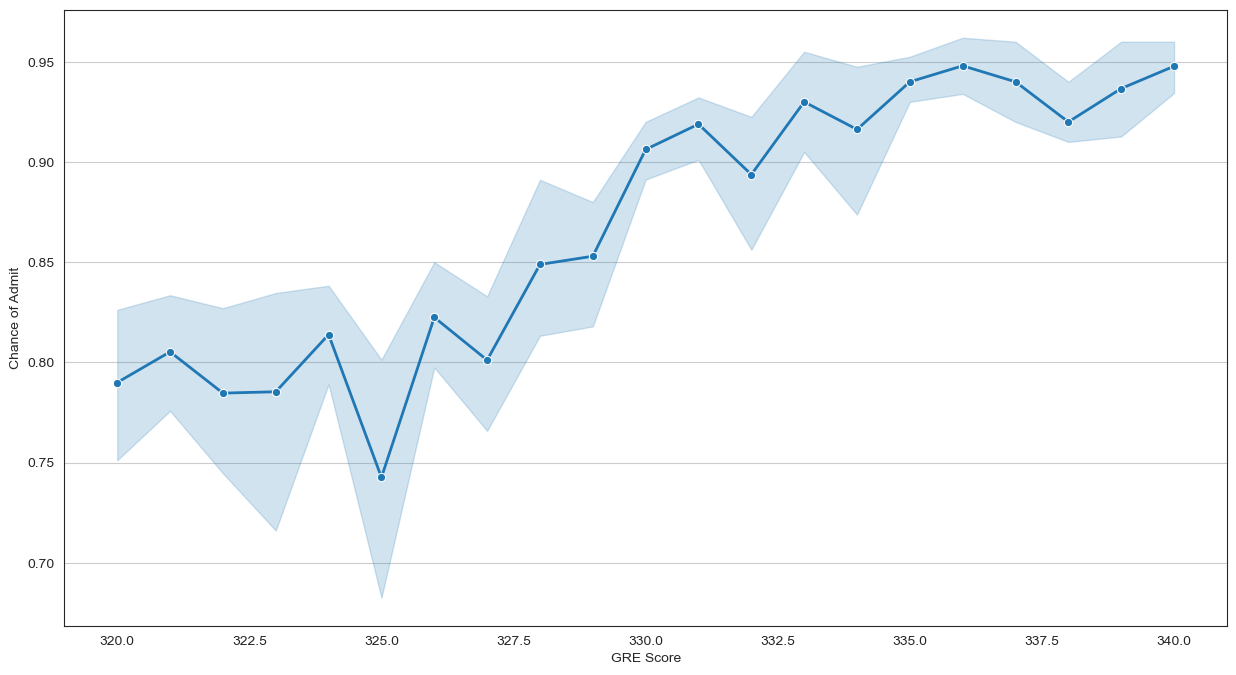

In [16]:
fig, ax = plt.subplots(figsize=(15,8))
gre_line = sns.lineplot(x='GRE Score', y='Chance of Admit', data=co_gre, linewidth=2, marker='o')
gre_line.yaxis.grid(True)
plt.show()

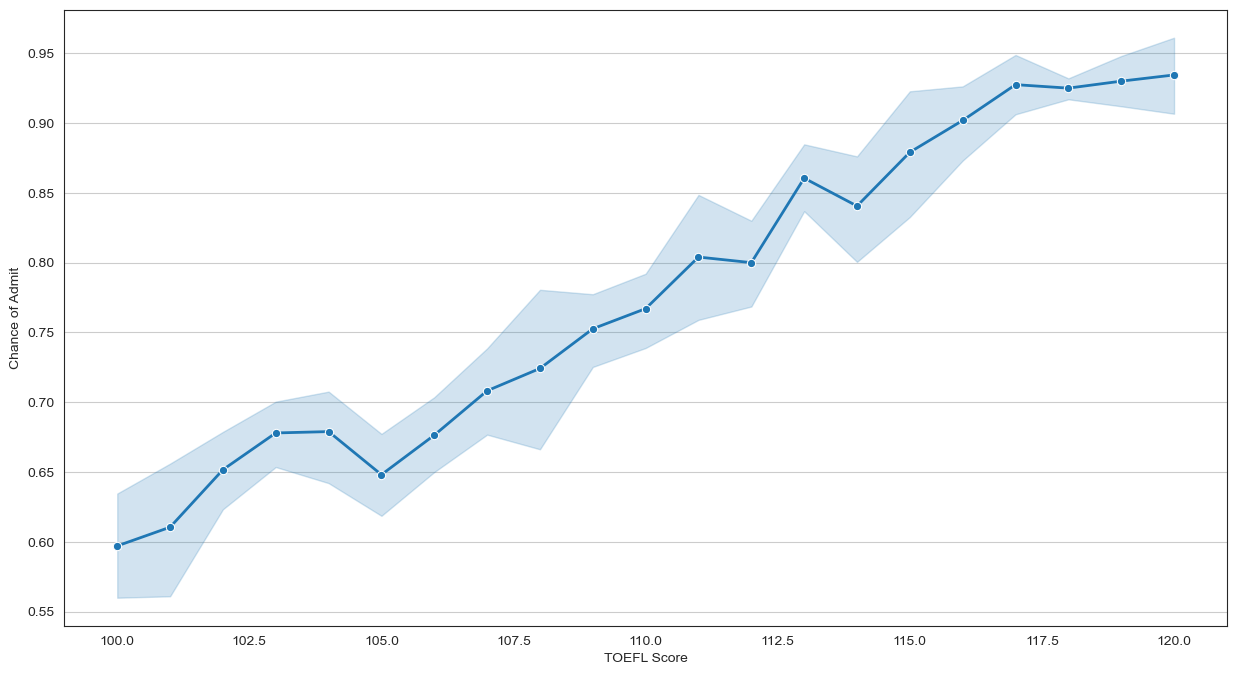

In [17]:
fig, ax = plt.subplots(figsize=(15,8))
toefl_line = sns.lineplot(x='TOEFL Score', y='Chance of Admit', data=co_toefl, linewidth=2, marker='o')
toefl_line.yaxis.grid(True)
plt.show()

Clearly, the above two graphs make it clear that higher the scores better the chance of admit.

In [18]:
print(f"Average GRE Score: {admissions['GRE Score'].mean():.2f} out of 340")
print(f"Average TOEFL Score: {admissions['TOEFL Score'].mean():.2f} out of 120")
print(f"Average CGPA: {admissions['CGPA'].mean():.2f} out of 10")
print(f"Average chance of getting admitted: {admissions['Chance of Admit'].mean() * 100:.2f}%")

Average GRE Score: 316.47 out of 340
Average TOEFL Score: 107.19 out of 120
Average CGPA: 8.58 out of 10
Average chance of getting admitted: 72.17%


### Classification and Regression

For our machine learning algorithms, we will utilize a 75-25 split for training and testing.

In [19]:
X = admissions.drop('Chance of Admit',axis=1)
y = admissions['Chance of Admit']

In [20]:
X.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,1,337,118,4,4.5,4.5,9.65,1
1,2,324,107,4,4.0,4.5,8.87,1
2,3,316,104,3,3.0,3.5,8.00,1
3,4,322,110,3,3.5,2.5,8.67,1
4,5,314,103,2,2.0,3.0,8.21,0


In [21]:
y.head()

0    0.92
1    0.76
2    0.72
3    0.80
4    0.65
Name: Chance of Admit, dtype: float64

### Classification: Random Forests

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import GridSearchCV

In [100]:
#Splitting the data for classification algorithms

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=101)

In [101]:
#If Chance of Admit greater than 75% we classify it as 1
y_train_c = [1 if each > 0.75 else 0 for each in y_train]
y_test_c  = [1 if each > 0.75 else 0 for each in y_test]

In [102]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    }

In [106]:
def plot_confusion_matrix(y_pred):
    print('00: True Negatives\n01: False Positives\n10: False Negatives\n11: True Positives\n')
    conf_matrix = confusion_matrix(y_true=y_test_c, y_pred=y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap='GnBu', alpha=0.75)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large') 
    plt.xlabel('Predictions', fontsize=14)
    plt.ylabel('Actuals', fontsize=14)
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()
    return None

In [107]:
def check_scores(y_pred):
    print('Precision: %.3f' % precision_score(y_test_c, y_pred))
    print('Recall: %.3f' % recall_score(y_test_c, y_pred))
    print('Accuracy: %.3f' % accuracy_score(y_test_c, y_pred))
    print('F1 Score: %.3f' % f1_score(y_test_c, y_pred))
    return None

In [108]:
from sklearn.ensemble import RandomForestClassifier
forest_model_test = RandomForestClassifier(max_depth=40,random_state=42)
forest_model_test.fit(X_train,y_train_c)
Y_random_model_test =forest_model_test.predict(X_test)
forest_param = {'n_estimators':[500,700,1000],'max_depth':[10,20,40,70]}
forest_Gridsearch = GridSearchCV(estimator=forest_model_test,param_grid=forest_param,cv=10,scoring='f1',n_jobs=-1)
forest_Gridsearch.fit(X_train,y_train_c)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(max_depth=40, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 40, 70],
                         'n_estimators': [500, 700, 1000]},
             scoring='f1')

In [109]:
forest_Gridsearch.best_params_

{'max_depth': 10, 'n_estimators': 1000}

In [110]:
forest_model_best= RandomForestClassifier(n_estimators=1000,max_depth=10)

In [111]:
forest_model_best.fit(X_train,y_train_c)

RandomForestClassifier(max_depth=10, n_estimators=1000)

In [112]:
forest_y_pred =forest_model_best.predict(X_test)

In [113]:
from sklearn.metrics import accuracy_score, PrecisionRecallDisplay, precision_score, recall_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [114]:
forest_confusion = confusion_matrix(forest_y_pred,y_test_c)
forest_confusion

array([[69,  7],
       [ 3, 46]], dtype=int64)

In [115]:
forest_model_best.score(X_test,y_test_c)

0.92

In [116]:
precision_score(y_test_c,forest_y_pred)

0.9387755102040817

In [117]:
recall_score(y_test_c,forest_y_pred)

0.8679245283018868

In [118]:
check_scores(forest_y_pred)

Precision: 0.939
Recall: 0.868
Accuracy: 0.920
F1 Score: 0.902


00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



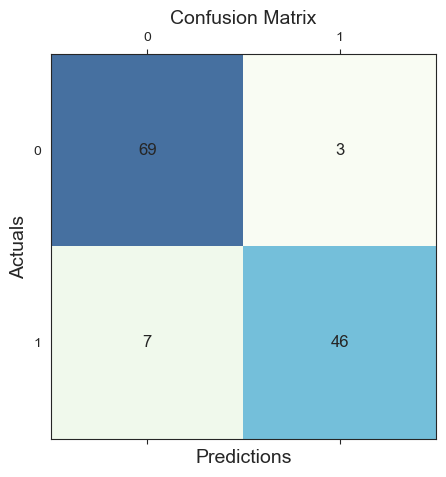

In [119]:
plot_confusion_matrix(forest_y_pred)

### Classification: Decision Trees

In [120]:
Tree_model = DecisionTreeClassifier()
Tree_model.fit(X_train,y_train_c)
Y_pred = Tree_model.predict(X_test)

In [121]:
decision_tree_confusion = confusion_matrix(Y_pred,y_test_c)
decision_tree_confusion

array([[63,  8],
       [ 9, 45]], dtype=int64)

In [122]:
accuracy_score(y_test_c,Y_pred)

0.864

In [123]:
Tree_model.score(X_test,y_test_c)

0.864

In [124]:
precision_score(y_test_c,Y_pred)

0.8333333333333334

In [125]:
recall_score(y_test_c,Y_pred)

0.8490566037735849

In [126]:
f1_score(y_test_c,Y_pred)

0.8411214953271028

In [127]:
check_scores(Y_pred)

Precision: 0.833
Recall: 0.849
Accuracy: 0.864
F1 Score: 0.841


00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



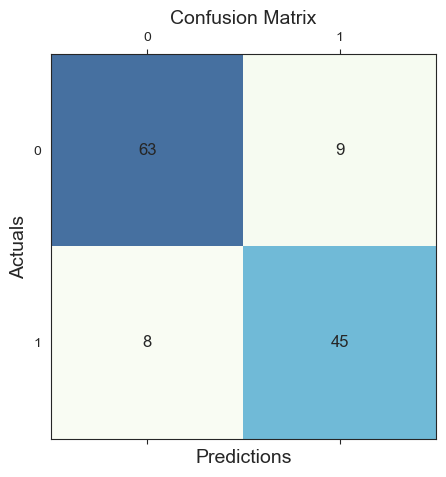

In [128]:
plot_confusion_matrix(Y_pred)

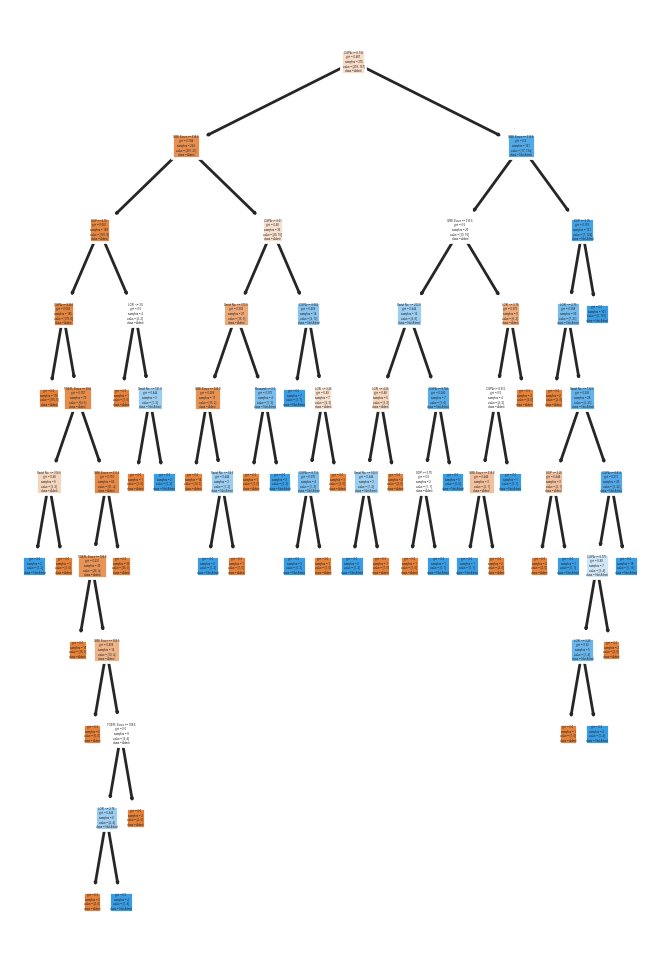

In [129]:
# Visualize the tree as a plot

admissions_classes = ["Admit", "Not Admit"]

admissions_features = admissions.columns.tolist()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 6), dpi=200)
plot_tree(Tree_model, filled=True, feature_names=admissions_features, class_names=admissions_classes, ax=axes)
plt.show()

### Classification: K Nearest Neighbors

In [130]:
best_k = None
best_accuracy = 0

for k in range(2, 15):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train_c)
    knn_prediction = knn.predict(X_test)

    accuracy = accuracy_score(y_test_c, knn_prediction)
    recall = recall_score(y_test_c, knn_prediction)
    precision = precision_score(y_test_c, knn_prediction)
    f1 = f1_score(y_test_c, knn_prediction)
    cm = confusion_matrix(y_test_c, knn_prediction)

    print("K =", k)
    print("Accuracy Score:", accuracy)
    print("Recall Score:", recall)
    print("Precision Score:", precision)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(cm)
    print("\n")

    # Update best_k if the current k gives a higher accuracy
    if accuracy > best_accuracy:
        best_k = k
        best_accuracy = accuracy

print("Best k based on accuracy:", best_k)

K = 2
Accuracy Score: 0.808
Recall Score: 0.6037735849056604
Precision Score: 0.9142857142857143
F1 Score: 0.7272727272727272
Confusion Matrix:
[[69  3]
 [21 32]]


K = 3
Accuracy Score: 0.856
Recall Score: 0.7547169811320755
Precision Score: 0.8888888888888888
F1 Score: 0.8163265306122449
Confusion Matrix:
[[67  5]
 [13 40]]


K = 4
Accuracy Score: 0.832
Recall Score: 0.660377358490566
Precision Score: 0.9210526315789473
F1 Score: 0.769230769230769
Confusion Matrix:
[[69  3]
 [18 35]]


K = 5
Accuracy Score: 0.864
Recall Score: 0.7924528301886793
Precision Score: 0.875
F1 Score: 0.8316831683168316
Confusion Matrix:
[[66  6]
 [11 42]]


K = 6
Accuracy Score: 0.848
Recall Score: 0.6981132075471698
Precision Score: 0.925
F1 Score: 0.7956989247311829
Confusion Matrix:
[[69  3]
 [16 37]]


K = 7
Accuracy Score: 0.888
Recall Score: 0.8301886792452831
Precision Score: 0.8979591836734694
F1 Score: 0.8627450980392157
Confusion Matrix:
[[67  5]
 [ 9 44]]


K = 8
Accuracy Score: 0.848
Recall Sco

In [131]:
# k with the best accuracy

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train_c)
knn_prediction = knn.predict(X_test)

accuracy = accuracy_score(y_test_c, knn_prediction)
recall = recall_score(y_test_c, knn_prediction)
precision = precision_score(y_test_c, knn_prediction)
f1 = f1_score(y_test_c, knn_prediction)
cm = confusion_matrix(y_test_c, knn_prediction)

print("Accuracy Score:", accuracy)
print("Recall Score:", recall)
print("Precision Score:", precision)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(cm)

Accuracy Score: 0.888
Recall Score: 0.8301886792452831
Precision Score: 0.8979591836734694
F1 Score: 0.8627450980392157
Confusion Matrix:
[[67  5]
 [ 9 44]]


00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



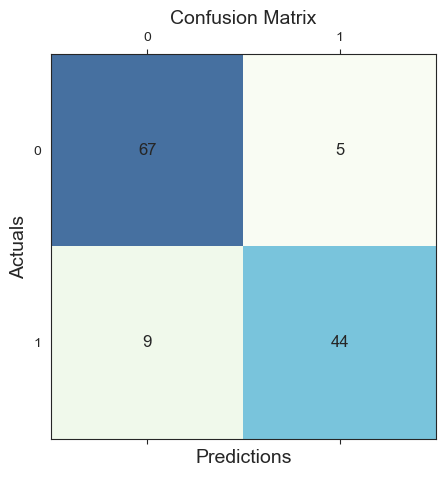

In [132]:
plot_confusion_matrix(knn_prediction)

### Regression

In [73]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.metrics import accuracy_score,mean_squared_error

In [74]:
#Splitting the data for regression algorithms
#Normalisation works slightly better for Regression.
X_norm=preprocessing.normalize(X)
X_train,X_test,y_train,y_test=train_test_split(X_norm,y,test_size=0.25,random_state=101)

In [75]:
regressors=[['Linear Regression :',LinearRegression()],
       ['Decision Tree Regression :',DecisionTreeRegressor()],
       ['Random Forest Regression :',RandomForestRegressor()],
       ['K-Neighbors Regression :',KNeighborsRegressor()]]
reg_pred=[]

for name,model in regressors:
    model=model
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    rms=np.sqrt(mean_squared_error(y_test, predictions))
    reg_pred.append(rms)
    print(name,rms)

Linear Regression : 0.08063165906838987
Decision Tree Regression : 0.11720409549158255
Random Forest Regression : 0.08306944034962553
K-Neighbors Regression : 0.11018675056466634


<AxesSubplot:>

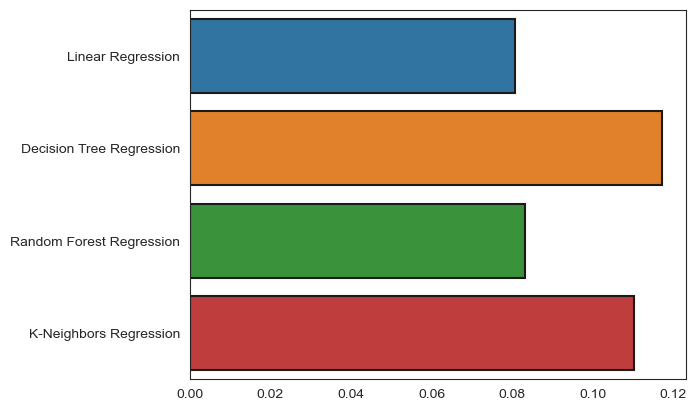

In [76]:
y_ax=['Linear Regression' ,'Decision Tree Regression', 'Random Forest Regression', 'K-Neighbors Regression']
x_ax=reg_pred

sns.barplot(x=x_ax,y=y_ax,linewidth=1.5,edgecolor="0.1")

In [84]:
#If Chance of Admit greater than 75% we classify it as 1
y_train_c = [1 if each > 0.75 else 0 for each in y_train]
y_test_c  = [1 if each > 0.75 else 0 for each in y_test]

In [87]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

classifiers=[['Linear Regression :',LinearRegression()],
       ['Decision Tree Regression :',DecisionTreeRegressor()],
       ['Random Forest Regression :',RandomForestRegressor()],
       ['K-Neighbors Regression :',KNeighborsRegressor()]]
cla_pred=[]

for name, model in classifiers:
    model.fit(X_train, y_train_c)
    predictions = model.predict(X_test)
    
    mae = mean_absolute_error(y_test_c, predictions)
    mse = mean_squared_error(y_test_c, predictions)
    r2 = r2_score(y_test_c, predictions)
    
    print(name)
    print('Mean Absolute Error:', mae)
    print('Mean Squared Error:', mse)
    print('R-squared:', r2)
    print('\n')

Linear Regression :
Mean Absolute Error: 0.26393405615186905
Mean Squared Error: 0.10318032652596093
R-squared: 0.5831097918142993


Decision Tree Regression :
Mean Absolute Error: 0.15
Mean Squared Error: 0.15
R-squared: 0.39393939393939414


Random Forest Regression :
Mean Absolute Error: 0.14239999999999997
Mean Squared Error: 0.076786
R-squared: 0.6897535353535355


K-Neighbors Regression :
Mean Absolute Error: 0.212
Mean Squared Error: 0.0944
R-squared: 0.6185858585858588




Random Forest Regression has the lowest values for both MAE and MSE, indicating better performance in terms of prediction accuracy.

Linear Regression has a relatively high R-squared value, suggesting that it explains a significant portion of the variance in the target variable.

Decision Tree Regression has lower performance compared to Random Forest but might be simpler and easier to interpret.

K-Neighbors Regression performs reasonably well but is outperformed by Random Forest in terms of MAE and MSE.

Random Forest Regression might be a strong candidate for the "best" model in this context.